In [1]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.covariance import LedoitWolf, EmpiricalCovariance, ShrunkCovariance, OAS, GraphLassoCV, MinCovDet, GraphLasso
import matplotlib.pyplot as plt
import pyfolio as pf
%matplotlib inline

# HRP

In [25]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1 - corr) / 2.) ** .5 # distance matrix
    return dist


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0]*2, 2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;
        j = df0.values - numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1], index=i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()


def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov, cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems, cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return cVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j, k in ((0,len(i)/2), \
            (len(i) / 2, len(i))) if len(i) > 1] # bi-section
        for i in xrange(0, len(cItems), 2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i + 1] # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [26]:
def metric(daily_ret):
    an_ret = pf.empyrical.annual_return(daily_ret)
    sharpe = pf.empyrical.sharpe_ratio(daily_ret)
    vol = pf.empyrical.annual_volatility(daily_ret)
    maxdraw = pf.empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

# 回测

In [16]:
DATA_DIR = 'D:Data/fund/history'

In [217]:
funds = [
         '002222', # 嘉实新趋势
         '070037', # 嘉实纯债A
#          '070013', # 嘉实研究精选A
         '001878', # 嘉实沪港深精选
         '001044', # 嘉实新消费
         '001758', # 嘉实研究增强
         '070022', # 嘉实领先成长
#          '000082', # 嘉实研究阿尔法
#          '001637', # 嘉实腾讯自选股大数据
        ]

In [218]:
df = pd.DataFrame()
for f in funds:
    fname = '%s/%s.OF.xlsx'%(DATA_DIR, f)
    print fname
    temp = pd.read_excel(fname, index_col=0)
    df[f] = temp['nav_adj']

D:Data/fund/history/002222.OF.xlsx
D:Data/fund/history/070037.OF.xlsx
D:Data/fund/history/001878.OF.xlsx
D:Data/fund/history/001044.OF.xlsx
D:Data/fund/history/001758.OF.xlsx
D:Data/fund/history/070022.OF.xlsx


In [219]:
ret_df = df.pct_change().dropna()

In [226]:
ret_df.head()

,002222,070037,001878,001044,001758,070022
2016-12-02 00:00:00.005,-0.000969,0.000000,-0.017312,-0.013820,0.0,-0.014644
2016-12-05 00:00:00.005,0.000000,0.000000,-0.002517,-0.013013,0.0,-0.007431
2016-12-06 00:00:00.005,-0.000970,-0.000846,0.003364,0.005071,0.0,-0.000535
2016-12-07 00:00:00.005,0.000971,-0.000847,0.008382,0.004036,0.0,0.007491
2016-12-08 00:00:00.005,0.000000,0.000847,-0.001663,0.002010,0.0,-0.004780


In [227]:
getRecBipart(ret_df[-60:].cov(), ret_df.columns)

002222    0.094366
070037    0.901298
001878    0.002120
001044    0.000958
001758    0.000590
070022    0.000668
dtype: float64

In [222]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.NAN
for date in ret_df.index:
    weight.loc[date] = wb
    if date.weekday() == 4:
        X_train = ret_df[ret_df.index <= date]
        if X_train.shape[0] >= 60:
            cov = X_train[-60:].cov()
            wb = getRecBipart(cov, ret_df.columns)
            wb = np.array(wb)

In [223]:
hrp_portfolio_ret = (weight * ret_df).sum(axis=1)

In [224]:
metric(hrp_portfolio_ret)

Annual return: 2.02%
Sharpe ratio: 5.48
Annual volatility: 0.68%
Max drawdown: -0.26%


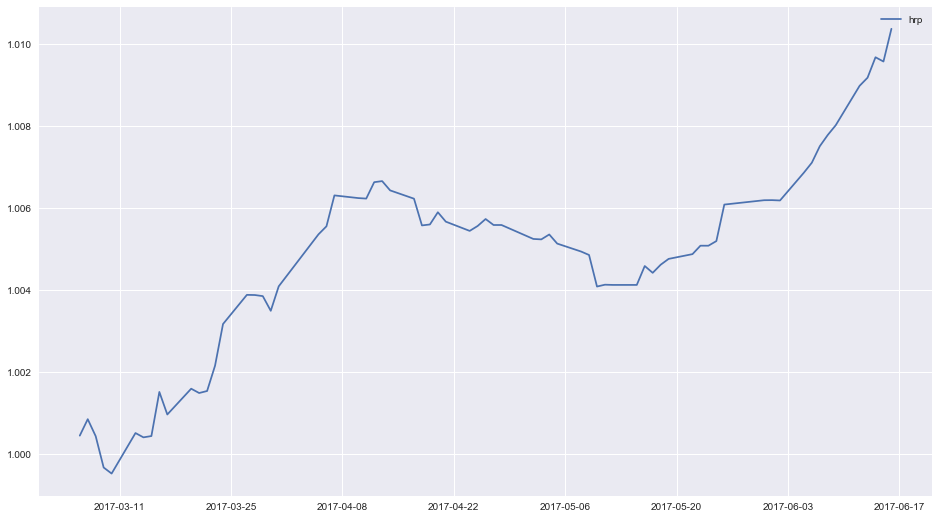

In [225]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
plt.legend()

## Ledoit-Wolf shrinkage

In [208]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.NAN
lw = LedoitWolf()
for date in ret_df.index:
    weight.loc[date] = wb
    if date.weekday() == 4:
        X_train = ret_df[ret_df.index <= date]
        if X_train.shape[0] >= 60:
            lw.fit(X_train)
            cov = pd.DataFrame(lw.covariance_, columns=ret_df.columns, index=ret_df.columns)
            wb = getRecBipart(cov, ret_df.columns)
            wb = np.array(wb)

In [209]:
lw_portfolio_ret = (weight * ret_df).sum(axis=1)

In [210]:
metric(lw_portfolio_ret)

Annual return: 1.68%
Sharpe ratio: 0.74
Annual volatility: 2.59%
Max drawdown: -5.11%


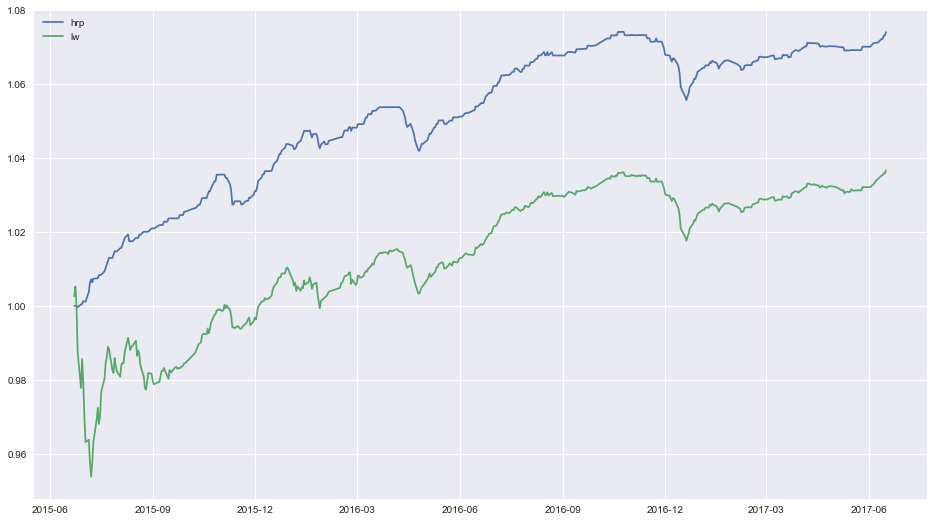

In [211]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
plt.plot((1+lw_portfolio_ret).cumprod(), label='lw')
plt.legend()

## Shrunk Covariance

In [212]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.NAN
sc = ShrunkCovariance(0.5)
for date in ret_df.index:
    weight.loc[date] = wb
    if date.weekday() == 4:
        X_train = ret_df[ret_df.index <= date]
        if X_train.shape[0] >= 60:
            sc.fit(X_train)
            cov = pd.DataFrame(sc.covariance_, columns=ret_df.columns, index=ret_df.columns)
            wb = getRecBipart(cov, ret_df.columns)
            wb = np.array(wb)

In [213]:
weight.tail()

,070037,070013,001044,070022
2017-06-12 00:00:00.005,0.854399,0.0654671,0.0478953,0.0322388
2017-06-13 00:00:00.005,0.854399,0.0654671,0.0478953,0.0322388
2017-06-14 00:00:00.005,0.854399,0.0654671,0.0478953,0.0322388
2017-06-15 00:00:00.005,0.854399,0.0654671,0.0478953,0.0322388
2017-06-16 00:00:00.005,0.854399,0.0654671,0.0478953,0.0322388


In [214]:
sc_portfolio_ret = (weight * ret_df).sum(axis=1)

In [215]:
metric(sc_portfolio_ret)

Annual return: 2.01%
Sharpe ratio: 0.50
Annual volatility: 4.70%
Max drawdown: -6.29%


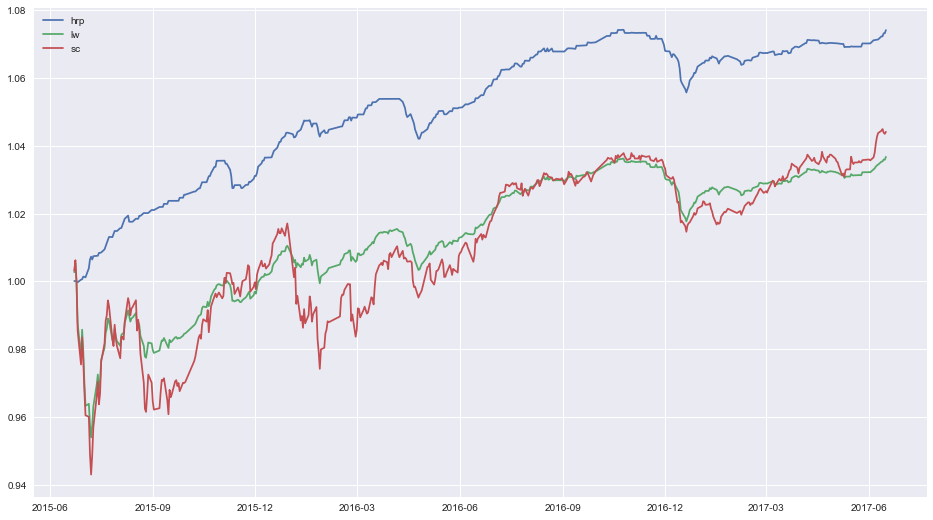

In [216]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
plt.plot((1+lw_portfolio_ret).cumprod(), label='lw')
plt.plot((1+sc_portfolio_ret).cumprod(), label='sc')
plt.legend()

## Oracle Approximating Shrinkage

In [181]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.NAN
oas = OAS()
for date in ret_df.index:
    weight.loc[date] = wb
    if date.weekday() == 4:
        X_train = ret_df[ret_df.index <= date]
        if X_train.shape[0] >= 60:
            oas.fit(X_train)
            cov = pd.DataFrame(oas.covariance_, columns=ret_df.columns, index=ret_df.columns)
            wb = getRecBipart(cov, ret_df.columns)
            wb = np.array(wb)

In [182]:
weight.tail()

,070037,070013,000082
2017-06-12 00:00:00.005,0.994521,0.00234131,0.00313747
2017-06-13 00:00:00.005,0.994521,0.00234131,0.00313747
2017-06-14 00:00:00.005,0.994521,0.00234131,0.00313747
2017-06-15 00:00:00.005,0.994521,0.00234131,0.00313747
2017-06-16 00:00:00.005,0.994521,0.00234131,0.00313747


In [183]:
oas_portfolio_ret = (weight * ret_df).sum(axis=1)

In [184]:
metric(oas_portfolio_ret)

Annual return: 4.55%
Sharpe ratio: 3.23
Annual volatility: 1.47%
Max drawdown: -3.21%


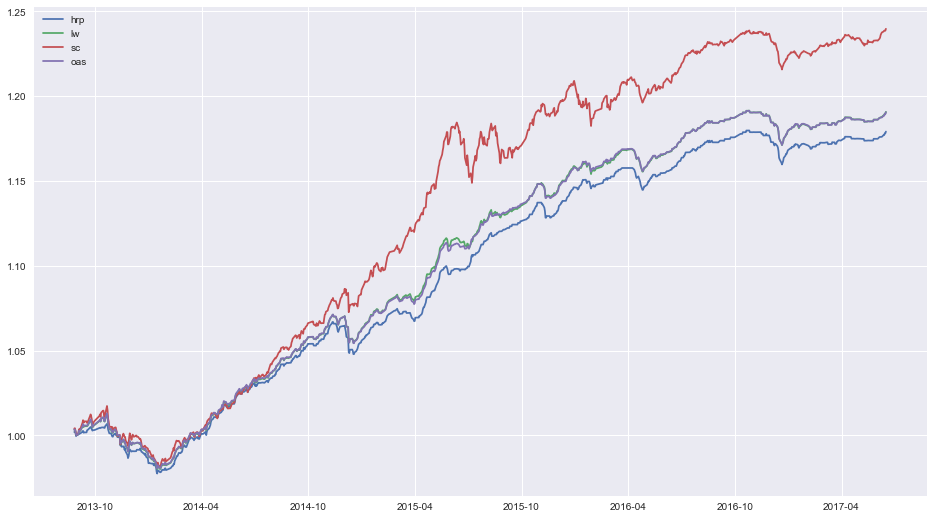

In [185]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
plt.plot((1+lw_portfolio_ret).cumprod(), label='lw')
plt.plot((1+sc_portfolio_ret).cumprod(), label='sc')
plt.plot((1+oas_portfolio_ret).cumprod(), label='oas')
plt.legend()